In [4]:
from glob import glob
import uproot as ur
import numpy as np
import json, os
import os.path as osp
from tqdm.auto import tqdm
from typing import Optional
from json import load
from phc import module_reload, plot_hist
module_reload('zhh')
from zhh import parse_sample_path, get_preselection_passes, ProcessIndex, \
    get_chunks_factual, EventCategories, sample_weight, presel_stack, \
    parse_json, get_pol_key, get_final_state_counts
version = 'v1'

REPO_ROOT = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH' if os.name != 'nt' else 'C:/DevRepositories/ZHH'
DATA_ROOT = f'/nfs/dust/ilc/user/bliewert/zhh'
INDEX_DIR = '/nfs/dust/ilc/user/bliewert/zhh/CreateRawIndex/v1'

processes = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/processes.npy")
samples = np.load(f"{INDEX_DIR if os.name != 'nt' else REPO_ROOT}/samples.npy")
chunks = np.load(f'{DATA_ROOT}/CreatePreselectionChunks/v1/chunks.npy') if os.name != 'nt' else np.load(f'{REPO_ROOT}/chunks_f.npy')

In [5]:
chunks_f = get_chunks_factual(f'{DATA_ROOT}/PreselectionFinal/{version}', chunks_in=chunks) if os.name != 'nt' else np.load(f'{REPO_ROOT}/chunks_f.npy')

In [4]:
np.save(f'{REPO_ROOT}/chunks_f.npy', chunks_f)

Validate chunks

In [5]:
subset = chunks_f[chunks_f['chunk_size_factual'] <= 0]
if len(subset) > 0:
    raise Exception(f"Invalid chunk length mismatch for branch <{subset['branch']}>")
else:
    print('Chunks OK')

Chunks OK


Introduce indices on samples and processes (included in future runs)

In [12]:
dtype_sample = ProcessIndex.dtype_sample
dtype_process = ProcessIndex.dtype_process

if not 'sid' in samples.dtype.names:
    samples_new = np.empty(len(samples), dtype=dtype_sample)
    samples_new['sid'] = np.arange(len(samples))
    for col in samples.dtype.names:
        samples_new[col] = samples[col]
        
    if len(samples) == len(samples_new):
        np.save(f'{INDEX_DIR}/samples.npy', samples_new)

if not 'pid' in processes.dtype.names:
    #processes_new = np.array([pids, *(processes[col] for col in processes.dtype.names)], dtype=dtype_process)
    processes_new = np.empty(len(processes), dtype=dtype_process)
    processes_new['pid'] = np.arange(len(processes))
    for col in processes.dtype.names:
        processes_new[col] = processes[col]

    if len(processes) == len(processes_new):
        np.save(f'{INDEX_DIR}/processes.npy', processes_new)
        
print('Conversion successful')

Conversion successful


Prototyping

In [16]:
if False:
    results = get_preselection_passes(f'{DATA_ROOT}/PreselectionFinal/{version}')
    np.save(f'{REPO_ROOT}/preselection.npy', results)
    results = np.load(f'{REPO_ROOT}/preselection.npy')

    for entry in results:
        print(f'{entry["proc_pol"]} | {entry["n_gen"]} events | wt: {entry["weight"]} | {entry["n_pass_llhh"]} : {entry["n_pass_vvhh"]} : {entry["n_pass_qqhh"]}')
        
    np.save(f'{REPO_ROOT}/results.npy', results)

  0%|          | 0/15497 [00:00<?, ?it/s]

In [15]:
from ast import literal_eval as make_tuple
import json

def test_meta_files(DATA_ROOT:str=f'{DATA_ROOT}/PreselectionFinal/{version}')->bool:
    files = glob(f'{DATA_ROOT}/*_Source.txt')
    #branches = list(map(lambda x: x.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0], files))

    for f in tqdm(files):
        branch = f.split(f'{DATA_ROOT}/')[1].split('_Source.txt')[0]
        
        if osp.isfile(f'{DATA_ROOT}/{branch}_FinalStateMeta.json'):
            with open(f, 'r') as file:
                src_spec = file.read()
                if src_spec.startswith('('):
                    src_file, chunk_start, chunk_end = make_tuple(src_spec)
                else:
                    src_file = src_spec
            
            # Read metadata
            with open(f'{DATA_ROOT}/{branch}_FinalStateMeta.json', 'r') as file:
                meta = json.load(file)

            n_gen = meta['nEvtSum']
            proc = meta["processName"]
            
            if proc == '' or n_gen == 0:
                print(src_file)
                raise Exception(branch)
    
    return True

In [16]:
test_meta_files()

  0%|          | 0/14449 [00:00<?, ?it/s]

True

Preselection Detailed

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
category_map = { key:value for key, value in EventCategories.EVENT_CATEGORY_TRUE.__dict__.items() if not key.startswith('__') and not callable(key)}
category_map_inv = { v: k for k, v in category_map.items() }

category_arr = np.zeros(len(category_map_inv.keys()), dtype=[('evt_cat', 'I'), ('name', '<U16')])
category_arr['evt_cat'] = list(category_map_inv.keys())
category_arr['name'] = list(category_map_inv.values())

mode = 'load'
save = False

if mode == 'prod':
    DATA_R = f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionFinal/{version}'
    branches = [14336]
    presel = 'llHH'
elif mode == 'debug':
    DATA_R = f'{REPO_ROOT}/output'
    branches = ['zhh']
    presel = 'llHH'

#get_final_state_counts(DATA_R, branches, chunks_f)

In [14]:
module_reload('zhh')
from zhh import presel_stack

if mode == 'prod-debug':
    # create PreselectionSummary results here
    presel_results = presel_stack(f'{DATA_ROOT}/PreselectionFinal/{version}', processes, chunks_f, [0,1])#chunks['branch'])
elif mode == 'prod':
    # use PreselectionSummary results        
    files = glob(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/[0-9]*.npy')
    size_tot = chunks_f['chunk_size_factual'].sum()
    presel_results = None
    pointer = 0

    for file in tqdm(files):
        part = np.load(file)
        if presel_results is None:
            presel_results = np.zeros(size_tot, dtype=part.dtype)
            
        presel_results[pointer:(pointer+len(part))] = part
        pointer += len(part)
elif mode == 'debug':
    branch = 'zhh'
    meta = parse_json(f'{REPO_ROOT}/output/{branch}_FinalStateMeta.json')
    
    chunks_f_deb = np.zeros(1, dtype=[('branch', f'<U{len(branch)}'), ('proc_pol', '<U32'), ('chunk_size_factual', 'I')])
    chunks_f_deb['branch'] = 'zhh'
    chunks_f_deb['proc_pol'] = f"{meta['processName']}_{get_pol_key(meta['polElectron'], meta['polPositron'])}"
    chunks_f_deb['chunk_size_factual'] = meta['nEvtSum']
    
    presel_results = presel_stack(f'{REPO_ROOT}/output', processes, chunks_f_deb, [branch], kinematics=True)
elif mode == 'load':
    presel_results = np.load(f'{REPO_ROOT}/presel_results.npy')

if mode != 'load':
    # Calculate weights
    pids = np.unique(presel_results['pid'])
    weights = np.zeros(len(pids), dtype=[('pid', 'H'), ('weight', 'f')])
    weights['pid'] = pids

    for pid in tqdm(pids):
        process = processes[processes['pid'] == pid][0]
        pol_em, pol_ep = process['pol_e'], process['pol_p']
        cross_sec = process['cross_sec']
        
        n_gen = np.sum(presel_results['pid'] == pid)
        
        weights['weight'][weights['pid'] == pid] = sample_weight(cross_sec, (pol_em, pol_ep), n_gen)
else:
    weights = np.load(f'{REPO_ROOT}/presel_weights.npy')
    
if save == True:
    np.save(f'{DATA_ROOT}/../../presel_results.npy', presel_results)
    np.save(f'{DATA_ROOT}/../../presel_weights.npy', weights)

In [9]:
category_map['ll']

17

In [161]:
module_reload('phc')
from phc import plot_hist

2f_z_bhabhang
(14077683,) (14077683,)
> 2f_z_bhabhang_LR
> 2f_z_bhabhang_RR
> 2f_z_bhabhang_RL
> 2f_z_bhabhang_LL
2f_z_l
(14077683,) (14077683,)
> 2f_z_l_RL
> 2f_z_l_LR
2f_z_bhabhag
(14077683,) (14077683,)
> 2f_z_bhabhag_RR
> 2f_z_bhabhag_LR
> 2f_z_bhabhag_LL
> 2f_z_bhabhag_RL


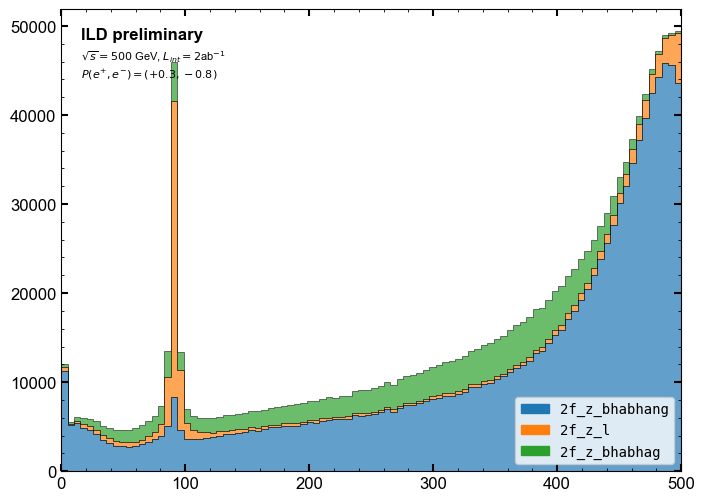

In [172]:
import datetime
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator
from matplotlib.legend_handler import HandlerTuple
from phc import get_colorpalette

def post_plot_ild(fig):
    fig.text(0.15, 0.83, 'ILD preliminary', fontsize=12, weight='bold', fontname='Arial')
    fig.text(0.15, 0.795, r'$\sqrt{s} = 500$ GeV, $L_{int} = 2$ab$^{-1}$', fontsize=8, fontname='Arial')
    fig.text(0.15, 0.765, r'$P(e^{+}, e^{-}) = (+0.3, -0.8)$', fontsize=8)
    
    for ax in fig.get_axes():
        for label in ax.get_xticklabels():
            label.update({'fontname': 'Arial'})
            
        for label in ax.get_yticklabels():
            label.update({'fontname': 'Arial'})
            
    ax = fig.get_axes()[0]
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_ticks_position('both')
    
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_ticks_position('both')
    
    ax.tick_params(axis='both', width=1.5, length=5)
    ax.tick_params(axis='both', which='both', direction='in')    

plot_dict = {}
covered_processes = []

for category in [17]:
    mask = (presel_results['event_category'] == category) & (presel_results['ll_mz'] > 0)
    pids = np.unique(presel_results['pid'][mask])
    
    for pid in pids:
        process_name = processes['process'][processes['pid'] == pid][0]
        
        if process_name in covered_processes:
            continue
        else:
            covered_processes.append(process_name)
        
        print(process_name)
        mask_process = np.zeros(len(mask), dtype='?')
        
        print(mask_process.shape, (presel_results['pid'] == pidc).shape)
        
        for pidc in processes['pid'][processes['process'] == process_name]:
            print(f"> {processes['proc_pol'][processes['pid'] == pidc][0]}")
            mask_process = mask_process | (presel_results['pid'] == pidc)
        
        plot_dict[process_name] = presel_results['ll_mz'][mask_process]
    
    fig = plot_hist(plot_dict, xlim=(0, 500), normalize=False, bins=96, custom_styling=True, stacked=True);
    #fig.suptitle(f'Identified as event category {category_map_inv[category]}')
    
    # Relies on ordered dicts
    cp = get_colorpalette()
    if False:
        i = 0
        ax = fig.get_axes()[0]
        
        for process_name in covered_processes:
            fig.text(0.5, 1 - 0.2*i,
                        process_name,
                        #color=colorpalette[i],
                        fontsize=10,
                        horizontalalignment='right',
                        verticalalignment='top',
                        transform=ax.transAxes)   
            i += 1
            
    patches_cmaps_gradients = []
    for i in range(len(covered_processes)):
        process_name = covered_processes[i]
        cmap_gradient = [Patch(facecolor=cp[i], edgecolor=cp[i], label=process_name)]
        patches_cmaps_gradients.append(cmap_gradient)
        
    plt.legend(handles=patches_cmaps_gradients, labels=covered_processes, fontsize=10, handler_map={list: HandlerTuple(ndivide=None, pad=0)})
    
post_plot_ild(fig)

In [17]:
category_map_inv

{0: 'OTHER',
 10: 'OTHER_LL',
 11: 'llHH',
 12: 'eebb',
 13: 'μμbb',
 14: 'ττbb',
 15: 'llbbbb',
 16: 'llqqH',
 17: 'll',
 18: 'llll',
 19: 'llqq',
 20: 'llvv',
 21: 'eeWW',
 22: 'llWW',
 30: 'OTHER_VV',
 31: 'vvHH',
 32: 'vvbb',
 33: 'vvbbbb',
 34: 'vvqqH',
 35: 'vv',
 36: 'vvqq',
 37: 'vvWW',
 50: 'OTHER_QQ',
 51: 'qqHH',
 52: 'qqqqH',
 53: 'qqbbbb',
 54: 'bbbb',
 55: 'ttZ',
 56: 'ttbb',
 57: 'qq',
 58: 'qqqq',
 59: 'bbbbbb',
 70: 'OTHER_TTBAR',
 71: 'evbbqq',
 72: 'μvbbqq',
 73: 'τvbbqq',
 80: 'OTHER_FULL_HADRONIC',
 81: 'bbqqqq',
 82: 'bbcssc',
 83: 'bbuddu',
 84: 'bbcsdu',
 90: 'OTHER_EVENTS',
 91: 'f5_any',
 95: 'f6_yyyyZ',
 96: 'f6_xxWW',
 97: 'f6_xxxxZ'}

2f_z_bhabhang 7206055 -999.0000610351562
2f_z_l 339187 -999.0000610351562
2f_z_bhabhag 292941 -999.0000610351562


c:\DevSw\miniforge3\envs\normflows\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\DevSw\miniforge3\envs\normflows\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


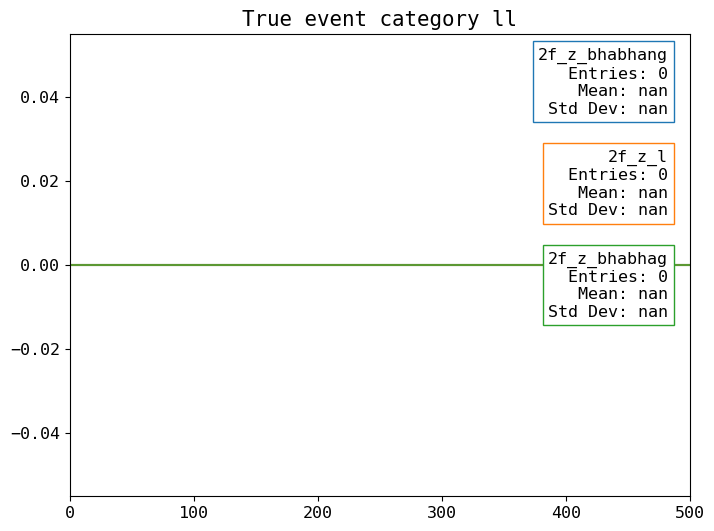

In [39]:
plot_dict = {}
covered_processes = []

for category in [17]:
    mask = presel_results['event_category'] == category
    pids = np.unique(presel_results['pid'][mask])
    
    for pid in pids:
        process_name = processes['process'][processes['pid'] == pid][0]
        
        if process_name in covered_processes:
            continue
        else:
            covered_processes.append(process_name)
        
        mask_process = np.zeros(len(mask), dtype='B')
        for pidc in processes['pid'][processes['process'] == process_name]:
            mask_process = mask_process | (presel_results['pid'] == pidc)
        
        mask_process = mask_process & mask
        
        print(f"{process_name} {np.sum(mask_process)} {np.average(presel_results['ll_mz'][mask_process])}")
        
        plot_dict[process_name] = presel_results['ll_mz'][mask_process]

    plot_hist(plot_dict, xlim=(0,500), title=f'True event category {category_map_inv[category]}');

In [20]:
np.unique(presel_results[presel_results['ll_mz'] > 0]['event_category'], return_counts=True)

(array([ 0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 35, 36, 37,
        52, 54, 57, 58, 70, 71, 72, 73, 82, 83, 95, 96, 97], dtype=uint8),
 array([      1,       5,    3439,    1035,      26,       3,      11,
        1567651,  174620,   22829,   41677,    1456,     423,       1,
           1258,       6,      61,       6,       1,    3014,     244,
           2488,      69,      11,      10,       1,       1,      67,
             72,       8], dtype=int64))

In [27]:
a = presel_results['event_category'] == 17
b = presel_results['ll_mz'] > 0

In [29]:
print(np.sum(a), np.sum(b), np.sum(np.bitwise_and(a, b)))

7838183 1820494 1567651


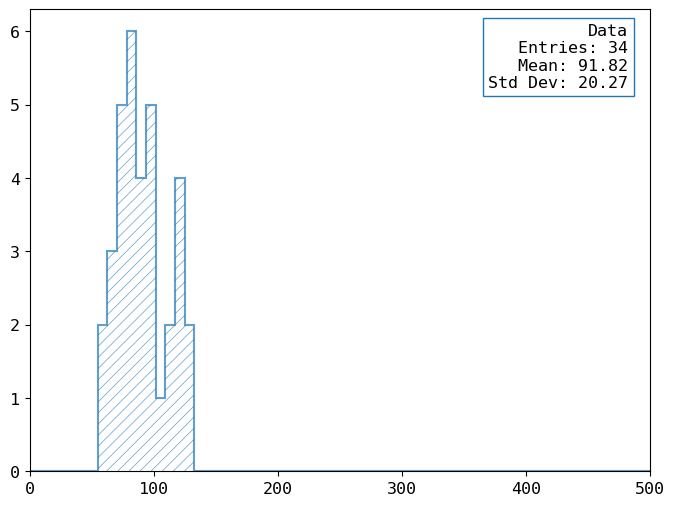

In [38]:
mask = (presel_results['ll_mz'] > 0) & (presel_results['event_category'] == 17) & (presel_results['ll_pass'] == 1)

plot_hist(presel_results[mask]['ll_mz'],
          bins=64, xlim=(0,500));

In [41]:
if False:
    presel_results = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_results.npy')
    weights = np.load(f'/nfs/dust/ilc/user/bliewert/zhh/PreselectionSummary/v1/presel_weights.npy')
else:
    np.save(f'{REPO_ROOT}/presel_results.npy', presel_results)
    np.save(f'{REPO_ROOT}/presel_weights.npy', weights)

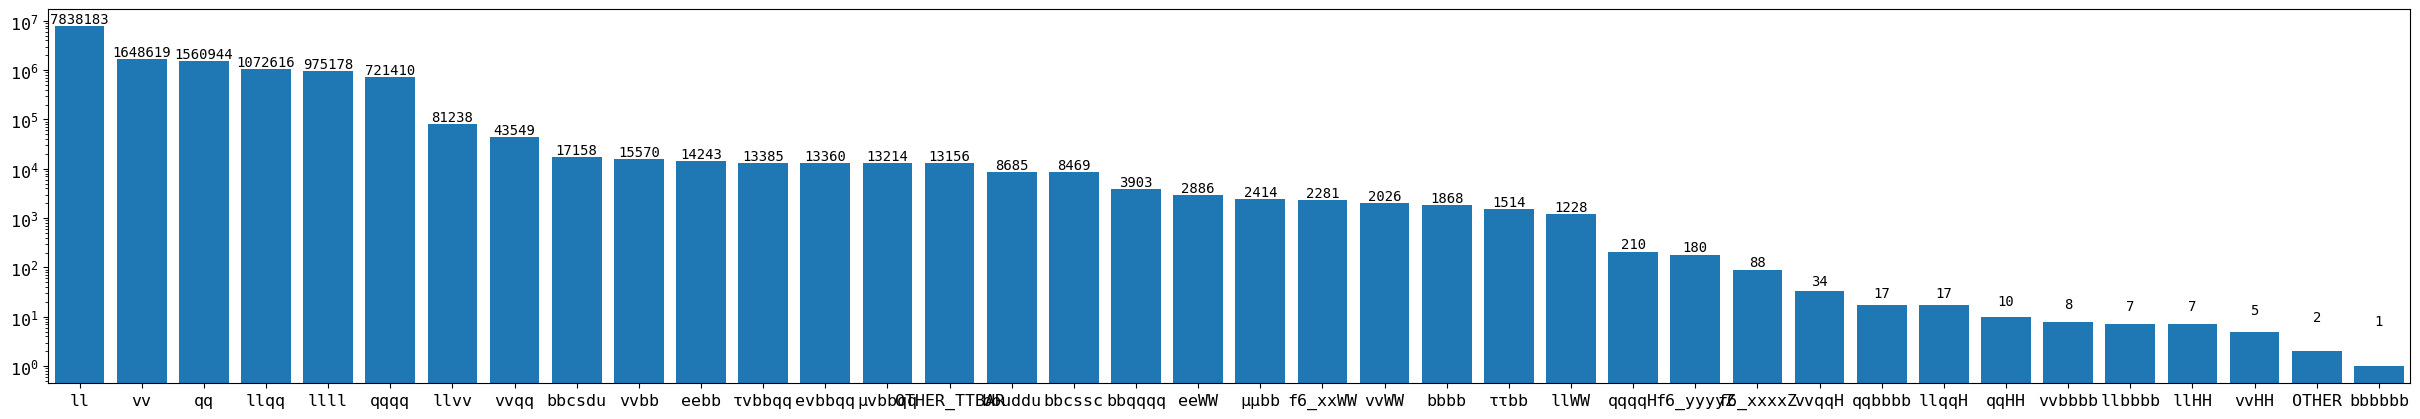

In [25]:
unq_cat, unq_counts = np.unique(presel_results['event_category'], return_counts=True)
mask = np.argsort(-unq_counts)

unq_cat = unq_cat[mask]
unq_counts = unq_counts[mask]
cat_counts = dict(zip(unq_cat, unq_counts))
unq_labels = category_arr['name'][np.isin(category_arr['evt_cat'], unq_cat)][mask]

fig, ax = plt.subplots(figsize=(24, 4))

ax.bar(unq_labels, unq_counts)
for rect, label in zip(ax.patches, unq_counts):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
ax.set_yscale('log')
ax.set_xlim(-0.5, len(unq_labels)-.5)
fig.set_tight_layout({"pad": .0})

In [29]:
unq_processes = np.unique(processes['process'])
expected_events = np.zeros(len(unq_processes), dtype=[('process', '<U60'), ('evt_expeceted', 'f')])
expected_events['process'] = unq_processes

for process_name in unq_processes:
    for process in processes[processes['process'] == process_name]:
        weight = weights['weight'][weights['pid'] == process['pid']][0]
        expected_events['evt_expeceted'][expected_events['process'] == process_name] += np.sum(chunks_f['chunk_size_factual'][chunks_f['proc_pol'] == process['proc_pol']])*weight
        
res = 0.
for process_name in ['e1e1hh', 'e2e2hh', 'e3e3hh']:
    res += expected_events['evt_expeceted'][expected_events['process'] == process_name][0]

print(f'expected llHH: {res:.2f} events')

expected llHH: 41.17 events


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

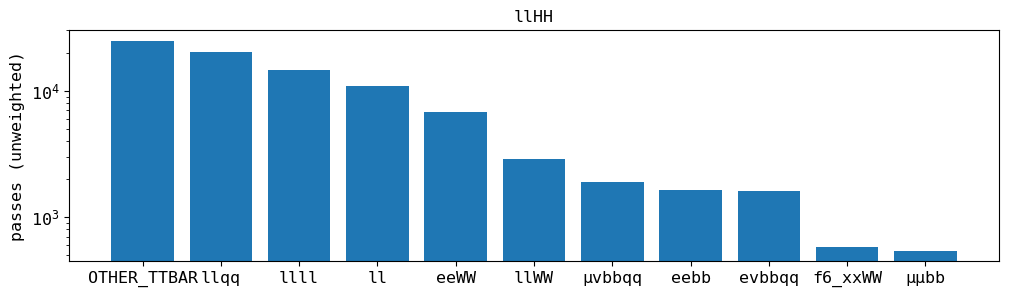

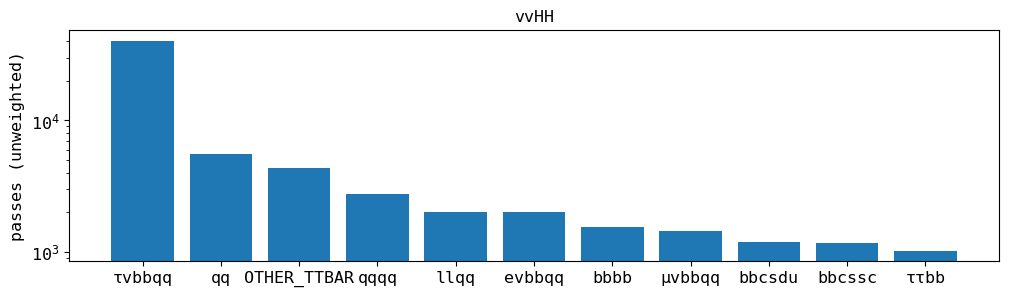

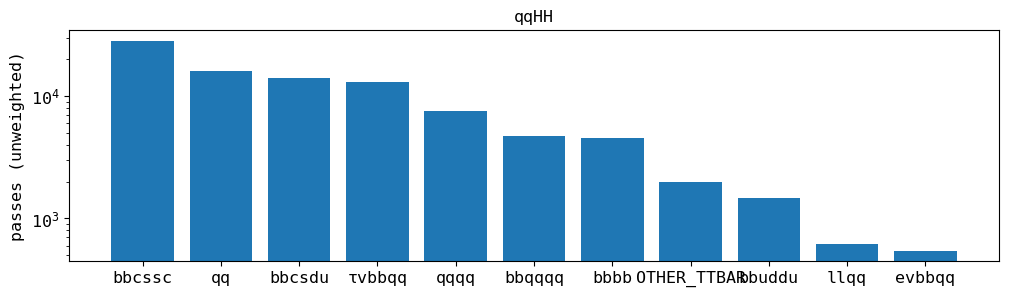

In [26]:
#event_categories = event_categories[event_categories != 0]
per_cat = {}

for presel in ['ll', 'vv', 'qq']:
    dtype = [
        ('category', 'i'),
        ('passes', 'f')
    ]
    passes_per_cat = np.zeros(len(unq_cat), dtype=dtype)
    passes_per_cat['category'] = unq_cat
    
    i = 0
    for category in tqdm(unq_cat):
        passes_per_cat[i]['category'] = category
        events = presel_results[presel_results['event_category'] == category]
        
        res = 0.
        for pid in np.unique(events['pid']):
            subset = events[events['pid'] == pid]
            res += np.sum(subset[f'{presel}_pass'] == 1) * weights['weight'][weights['pid'] == pid][0]
        
        passes_per_cat[i]['passes'] = res #/ cat_counts[category]
        
        i += 1
            
    per_cat[presel] = passes_per_cat
        
    sorted = passes_per_cat[np.argsort(-passes_per_cat['passes'])][:11]
    categories = []
    for s in sorted:
        categories.append(category_map_inv[s['category']])
    
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(categories, sorted['passes'])
    ax.set_title(f'{presel}HH')
    ax.set_yscale('log')
    ax.set_ylabel('passes (unweighted)')

In [24]:
presel_results[presel_results['event_category'] == category_map['OTHER']]

array([(13569, 259, 0, 0, 0, 0, 0), (13570, 262, 0, 0, 0, 0, 0)],
      dtype=[('branch', '<i4'), ('pid', '<u2'), ('event', '<u4'), ('event_category', 'u1'), ('ll_pass', 'u1'), ('vv_pass', 'u1'), ('qq_pass', 'u1')])

In [27]:
pres = presel_results[presel_results['event_category'] == category_map['OTHER_TTBAR']]
subset = pres[['branch', 'event']]

In [29]:
branches = np.unique(subset['branch'])
print(len(branches))

1441


In [36]:
module_reload('zhh')
from zhh import get_final_state_counts

fsc = get_final_state_counts(DATA_R, branches, chunks_f)

  0%|          | 0/1441 [00:00<?, ?it/s]

In [37]:
fsc

array([(13680,  88168, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (13680,  88169, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       (13680,  88170, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
       ...,
       (15483, 178527, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0),
       (15483, 178528, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0),
       (15483, 178529, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0)],
      dtype=[('branch', '<i4'), ('event', '<u4'), ('Nd', 'u1'), ('Nu', 'u1'), ('Ns', 'u1'), ('Nc', 'u1'), ('Nb', 'u1'), ('Nt', 'u1'), ('Ne1', 'u1'), ('Nn1', 'u1'), ('Ne2', 'u1'), ('Nn2', 'u1'), ('Ne3', 'u1'), ('Nv3', 'u1'), ('Ng', 'u1'), ('Ny', 'u1'), ('NZ', 'u1'), ('NW', 'u1'), ('NH', 'u1')])